In [72]:
## Load modules
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
cwd = os.getcwd() # current working directory

In [73]:
import sys
sys.path.append(os.path.abspath(cwd))

In [74]:
## Load data
#data_dir = "cycle_10bins_conditions_none"#"2sec_data_avg" # name of the data folder

# Loading the train, dev, test data from specified folder
#os.chdir(cwd+"/"+data_dir+"/train")
#x_train = genfromtxt("x_train.csv", delimiter=',')
#y_train = genfromtxt("y_train.csv", delimiter=',')

In [75]:
# data (num_samples, features)
basedir = '/Users/Mike/Dropbox/Research/Stanford/Lele/AWS_2016-06_Multi-Height_Time_Series/'
windFile = 'Firewheel_FWL'+str(1)+'_mast_file_tsec_72-months.csv'
def importWindFile(basedir, windFile):
    data = np.loadtxt(basedir+windFile, delimiter=',', skiprows=7)
    ws = np.zeros((data.shape[0],5))
    time = np.linspace(0., 10.*data.shape[0],data.shape[0])
    nt = ws.shape[0]
    hour = data[:,3]
    month = data[:,1]
    for i  in range(0,5):
        ind = 5*(i+1)
        ws[:,i] = data[:,ind]
    return ws, hour, time, nt, month
ws, hour, time, nt, month = importWindFile(basedir, windFile)


In [156]:
nt = 1000
horizon = 18
n_train = nt-horizon
x_train = np.zeros((horizon-1,n_train))
y_train = np.zeros((n_train,1))
dataHeight = 0 # index of the height we want
for i in range(horizon,nt):
    x_train[:,i-horizon] = ws[i-horizon:i-1,dataHeight]
    y_train[i-horizon] = ws[i,dataHeight]
x_train = x_train.T

In [157]:
#print(x_all.shape)
#x_train = x_all[10:110,10:20] # (100,10)
data_size, features = x_train.shape

In [158]:
def normalize_data(data):
    mu = np.mean(data,axis=0) # compute the mean along axis = 0 (num_samples for raw data)
    cov = np.std(data,axis=0) # using std instead of variance seems to be best
    return mu, cov # returning the normalizations for the data

x_mu, x_cov = normalize_data(x_train) # x_train is (features x num_samples)
y_mu, y_cov = normalize_data(y_train) # x_train is (features x num_samples)

#y_mu, y_cov = normalize_data(y_train)

X_train = ((x_train - x_mu)/x_cov).T # still in (features, data_samples)
#X_train = x_train.T
Y_train = np.squeeze(y_train)
#Y_train = ((y_train - y_mu)/y_cov).T # still in (features, data_samples)
#Y_train = 0.5*X_train[1,:].T
#print(np.mean(X_train[:,1]))
#X_dev = ((x_dev - x_mu)/x_cov).T # Use same distrib for others --> don't use "future" data
#X_test = ((x_test - x_mu)/x_cov).T
print(X_train.shape)
print(Y_train.shape)

(17, 982)
(982,)


In [159]:
def initialize_parameters(num_hid_layers, size_hid_layers, n_x, output_size):
    parameters = {}
    total_layers = num_hid_layers+1
    
    for l in range(1,total_layers+1):
        if l == 1:
            a = size_hid_layers
            b = n_x
        elif l == total_layers:
            a = output_size
            b = size_hid_layers
        else:
            a = size_hid_layers
            b = size_hid_layers
            
        parameters['w' + str(l)] = tf.get_variable('w'+str(l), [a, b], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(l)] = tf.get_variable('b'+str(l), [a,1], initializer = tf.zeros_initializer())    
    return parameters

In [160]:
def forward_prop(X,parameters):
    total_layers = len(parameters)//2
    layer_outputs = {}
    layer_outputs['A0'] = X
    
    for l in range(1,total_layers+1):
        layer_outputs['Z' + str(l)] = tf.matmul(parameters['w' + str(l)],layer_outputs['A' + str(l-1)])+parameters['b' + str(l)]
        layer_outputs['A' + str(l)] = tf.nn.relu(layer_outputs['Z' + str(l)])
        #layer_outputs['A' + str(l)] = tf.nn.dropout(layer_outputs['A' + str(l)],keep_prob)
    
    return layer_outputs['Z' + str(total_layers)]

In [161]:
def model(X_train, Y_train, learning_rate, num_epochs, num_hid_layers, size_hid_layers, minibatch_size, print_interval=10,plotting = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    losses = []                                        # To keep track of the cost
    train_errs = []                                        # To keep track of the cost
    eps = 10**-8.
    
    O = 1 # output size?
    
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[None])
    
    parameters = initialize_parameters(num_hid_layers, size_hid_layers, n_x, O)
    out = forward_prop(X, parameters)
    
    loss = tf.reduce_mean(tf.squared_difference(out, Y)) # L2 loss --> not good for our problem
    #loss = tf.reduce_mean(tf.losses.absolute_difference(Y,tf.squeeze(out))) # L1 loss
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Optimizer, change the learning rate here

    init = tf.global_variables_initializer() # When init is run later (session.run(init)),
    with tf.Session() as sess: # starting tf session --> all computation on tf graph in this with struct
        sess.run(init)
        for epoch in range(num_epochs+1):
            _, loss_val = sess.run([optimizer, loss], feed_dict={X: X_train, Y: Y_train})
            losses.append(loss_val)
            if epoch % (num_epochs/print_interval) == 0:
                print("Loss: ",loss_val)
                # Output the predictions
                train_pred = sess.run(out, feed_dict={X: X_train})
                #dev_pred = sess.run(out, feed_dict={X: X_dev})
                train_pred = np.squeeze(train_pred)
                train_err = np.mean(np.divide(abs((train_pred - Y_train)),Y_train+eps)) # absolute error
                print(train_err)
                #dev_err = np.mean(abs((dev_pred - Y_dev)/Y_dev))
                train_errs.append(train_err)
        if plotting:
            # Plot percent errors during iterations
            plt.plot(np.squeeze(train_errs))
            print(train_errs)
            #plt.plot(np.squeeze(dev_errs))
            #plt.xlim(0, plot_interval)
            #plt.ylim(0, np.min(train_errs)*10)
            plt.ylabel('Percent error')
            #plt.xlabel('iterations every '+str(num_epochs/plot_interval))
            plt.title("Error for learning rate = " + str(learning_rate))
            plt.show()
                
    
    results = train_err

('Loss: ', 67.262405)
0.767450444901
('Loss: ', 0.26362479)
0.048790829467
('Loss: ', 0.034512047)
0.0174611312151
('Loss: ', 0.07575316)
0.0315155477511
('Loss: ', 0.011741927)
0.0140221079102
('Loss: ', 0.10666064)
0.0392382362306
('Loss: ', 0.0065457961)
0.00964958819987
('Loss: ', 0.086410016)
0.0253766622858
('Loss: ', 0.12852025)
0.048012140039
('Loss: ', 0.0015538384)
0.00335031218081
('Loss: ', 6.7502813e-05)
0.000955961392985
[0.76745044490126679, 0.048790829467007003, 0.017461131215089364, 0.031515547751097495, 0.014022107910186914, 0.039238236230550824, 0.0096495881998747059, 0.025376662285819675, 0.04801214003904377, 0.003350312180809837, 0.00095596139298522657]


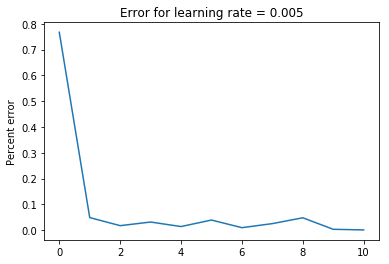

In [166]:
learning_rate = 0.005#0.0005
num_epochs = 5000 # total number of epochs to iterate through
print_interval = 10 # number of prints per total run
minibatch_size = 10
num_hid_layers = 5
size_hid_layers = 128

results=model(X_train, Y_train, learning_rate, num_epochs, num_hid_layers, size_hid_layers, minibatch_size, print_interval)

In [165]:
print(results)

None
